# P5-04: Prediction and post-processing of the masks
Post-processing with two versions:
- Contour code, standard library
- Chain code in python

## Libraries, modules

In [ ]:
# Imports
import numpy as np
import torch
from skimage.io import imread
from skimage.transform import resize
import os
from PIL import Image
import pickle # to save
from scipy import ndimage
# PL - Pinckaers, Litjens
from  MODULE.PL.metrics import ObjectDice, ObjectHausdorff, F1score
# JS -Schmidt
from MODULE.JS.unet import UNet
# JH - Jonas Heinke
# Configuration data
from configuration_CRAG import Path   as PATH     # Paths and filenames
from configuration_CRAG import Inputs as INPUT       # Image parameters
from configuration_CRAG import CfgModel as CFG_MODEL # Model parameters
from configuration_CRAG import Postprocess as POST    # post processing
from configuration_CRAG import EXPERIMENT      # Name of the experiment
# Image operations, chain code, converting
import MODULE.JH.image_processing as IP
# Transformations
from MODULE.JH.img_array_transform import ArrayTransform as TRANSFORM
# Prediction with adjustments
from MODULE.JH.prediction import Prediction as PREDICTION
# View image mask sets
from MODULE.JH.visualize import Show as SHOW


In [ ]:
# for control
VERBOSE=True
# Experiment
print(EXPERIMENT)

CRAG(development_2021_10_27_praezision_14)_blocks6_cout2_optSGD_lr0.1_ep150_h768_w768_ft32


## 1. List of file paths of the test data

In [ ]:
path=PATH() # Instance of the class required for method call.
# Source paths of the test images and test masks.
# HIER ANPASSEN FÜR DATENSET !!!
path_images=path.testimages
path_masks=path.testmasks
if INPUT.divide:
  path_images = path.sub_testimages
  path_masks = path.sub_testmasks

# Source path of the trained model.
path_model_experiment=path.model / EXPERIMENT
# Destination path for results of the experiment
path_result_experiment   = path.results  / EXPERIMENT
if not os.path.exists(path_result_experiment):
    os.mkdir(path_result_experiment)
# input and masks files
image_filenames  = path.get_filenames(path_images, dateifilter= '*.png', sort=True)
mask_filenames   = path.get_filenames(path_masks,  dateifilter= '*.png', sort=True)

In [ ]:
print('Number of image-mask pairs (samples) for prediction: ',len(image_filenames),' : ', len(mask_filenames))
if VERBOSE:
    for idx in range(len(image_filenames)):
        print(idx, ' | ', os.path.basename(image_filenames[idx]),'\t-> ', os.path.basename(mask_filenames[idx]))

Number of image-mask pairs (samples) for prediction:  40  :  40
0  |  test_1.png 	->  test_1.png
1  |  test_10.png 	->  test_10.png
2  |  test_11.png 	->  test_11.png
3  |  test_12.png 	->  test_12.png
4  |  test_13.png 	->  test_13.png
5  |  test_14.png 	->  test_14.png
6  |  test_15.png 	->  test_15.png
7  |  test_16.png 	->  test_16.png
8  |  test_17.png 	->  test_17.png
9  |  test_18.png 	->  test_18.png
10  |  test_19.png 	->  test_19.png
11  |  test_2.png 	->  test_2.png
12  |  test_20.png 	->  test_20.png
13  |  test_21.png 	->  test_21.png
14  |  test_22.png 	->  test_22.png
15  |  test_23.png 	->  test_23.png
16  |  test_24.png 	->  test_24.png
17  |  test_25.png 	->  test_25.png
18  |  test_26.png 	->  test_26.png
19  |  test_27.png 	->  test_27.png
20  |  test_28.png 	->  test_28.png
21  |  test_29.png 	->  test_29.png
22  |  test_3.png 	->  test_3.png
23  |  test_30.png 	->  test_30.png
24  |  test_31.png 	->  test_31.png
25  |  test_32.png 	->  test_32.png
26  |  test_33.p

## 2. Read in images and masks
- The size of the test images and test masks correspond to the training. Scaling is done accordingly.

In [ ]:
# read images and store them in memory.
images = [imread(img_name) for img_name in image_filenames]
actual_masks = [imread(mask_name) for mask_name in mask_filenames]
# Resize images and targets.
images_res = [resize(img, (INPUT.h_res, INPUT.w_res, INPUT.c_res)) for img in images]
resize_kwargs = {'order': 0, 'anti_aliasing': False, 'preserve_range': True}
actual_masks_res = [resize(mask, (INPUT.h_res, INPUT.w_res), **resize_kwargs) for mask in actual_masks]
# Namber of samples
sample_anzahl=len(images)
#Test# sample_anzahl=3

## 3. Set up the model und
## 4. Trainiertes Modell laden
Prediction parameters must correspond to the training parameters. Common configuration supports this process.


In [ ]:
# Determination of the available device (CPU, GPU).
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model
model = UNet(in_channels=INPUT.c_res,
             out_channels= CFG_MODEL.c_out,
             n_blocks=CFG_MODEL.n_blocks,
             start_filters=CFG_MODEL.ft,
             activation='relu',
             normalization='batch',
             conv_mode='same',
             dim=2).to(device)

model_weights = torch.load(path_model_experiment/ 'model')
model.load_state_dict(model_weights)

<All keys matched successfully>

## 5. Prognose

In [ ]:
# Prediction of the segmentation mask
prediction=PREDICTION(model, device, True)
predict_masks = [prediction.mask(img) for img in images_res]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


### Evaluation
- Here just for checking purposes, see project "P5-05 result visualization"

In [ ]:
transform=TRANSFORM()
dice, hausdorff, f1, dice_full = 0, 0, 0, 0
i_error=0
anzahl=0
# Table header
print_string=(f' idx | dice-idx  | f1-score  | weighted shape | actual masks       | predict masks')
print(print_string)
for idx in range(sample_anzahl):
    try:
        predict_mask_two= transform.twoClasses(predict_masks[idx])
        actual_masks_two= transform.twoClasses(actual_masks_res[idx])
        dice_img = ObjectDice(predict_mask_two,        actual_masks_two)
        f1_img = F1score(predict_mask_two,              actual_masks_two)
        hausdorff_img = ObjectHausdorff(predict_mask_two,  actual_masks_two)
        dice += dice_img
        f1 += f1_img
        hausdorff += hausdorff_img
        print_string=(f' {idx:3d} | {dice_img:9.3f} | {f1_img:9.3f} | {hausdorff_img:13.3f} | {os.path.basename(mask_filenames[idx])} | predict_masks[{idx+1:-02d}])')
        print(print_string)
        anzahl +=1
    except:
        i_error +=1
        print('Error: ',i_error, 'Cycle: ', idx)

 idx | dice-idx  | f1-score  | weighted shape | actual masks       | predict masks
   0 |     0.886 |     1.000 |        34.015 | test_1.png | predict_masks[01])
   1 |     0.909 |     1.000 |        89.006 | test_10.png | predict_masks[02])
   2 |     0.790 |     1.000 |       570.040 | test_11.png | predict_masks[03])
   3 |     0.827 |     1.000 |       193.259 | test_12.png | predict_masks[04])
   4 |     0.799 |     1.000 |       115.004 | test_13.png | predict_masks[05])
   5 |     0.960 |     1.000 |        21.095 | test_14.png | predict_masks[06])
   6 |     0.811 |     1.000 |       115.109 | test_15.png | predict_masks[07])
   7 |     0.961 |     1.000 |        43.863 | test_16.png | predict_masks[08])
   8 |     0.933 |     1.000 |       112.432 | test_17.png | predict_masks[09])
   9 |     0.851 |     1.000 |       275.530 | test_18.png | predict_masks[10])
  10 |     0.962 |     1.000 |       142.636 | test_19.png | predict_masks[11])
  11 |     0.901 |     1.000 |        

In [ ]:
print('-- Mean values ------------------------------------')
print('ObjectDice:', dice / anzahl )
print('F1:', f1 / anzahl )
print('Weighted shape:', hausdorff / anzahl) # weighted shape = hausdorff
print('Number io.: ', anzahl)
print('Errors: ', i_error)

-- Mean values ------------------------------------
ObjectDice: 0.8933089649592908
F1: 1.0
Weighted shape: 156.2120533196284
Number io.:  40
Errors:  0


## 6. Post-processing of the predicted masks (-> object masks) and code to outline the predicted glands and their identification
Two alternative variants
- Remove small objects
- Separate objects as far as possible (binary intensity morphology)
- Outline
- Set IDs

Binary intensity morphology with module: scipy.ndimage
- Separating objects.
- Can only differentiate between two states (background and object).
- But can emphasize a very specific object and separate it from one another.
Konur code with module: skimage.measure
- Can outline objects and assign object-specific IDs
- Empty areas of the objects can be filled

In [ ]:
# Lists
contour_codes_list=[]
# object_filled_list=[]
predict_masks_morph_list=[]
object_array_list=[]

In [ ]:
# VARIANT 2 - contour code (library / module: skimage.measure)
# Identification of the objects, variant 2
if POST.ident=='measure':
    # Fill holes
    idObjects= IP.ObjectIDsOfArray()
    for idx in range(sample_anzahl):
        mask_morph=idObjects.fill_objects(predict_masks[idx], POST.opening_structure)
        contur_codes, object_array=idObjects.getObjects(mask_morph)
        predict_masks_morph_list.append(mask_morph)
        object_array_list.append(object_array)
        contour_codes_list.append(contur_codes) 


In [ ]:
convert=IP.Convert() # Instance to convert
# VARIANT 1: CHAINCODE (Python)
if POST.ident=='chain':
    for idx in range(sample_anzahl):
        mask_morph=ndimage.binary_opening(predict_masks[idx], structure=np.ones(POST.opening_structure)).astype(int)
        # -> Returns: 0 = no object or 1 = object
        print('\n--- Mask idx: ', idx)
        idObject= IP.IdentifyObject(mask_morph, False) # Klasseninstanz MODUL
        # class-id - areas with this id are processed
        # id_ - The elements of the area receive this id
        chaincodes, object_array, fill_array=idObject.chaincode(class_id=1, id_=1)       # Klassenmethode
        # Converts chain code to contour array
        contour_codes=convert.chains_to_contourcodes_2(chaincodes)
        predict_masks_morph_list.append(mask_morph)
        contour_codes_list.append(contour_codes)
        object_array_list.append(object_array) 

## Save object arrays and contour codes

In [ ]:
# Control dimensions
if VERBOSE:
    print('Input images:   ', images_res[0].shape)
    print('Actual masks:  ',  actual_masks_res[0].shape)
    print('Prediction masks: ', predict_masks[0].shape)
    print('Path of model: ', path_model_experiment)
    print('Path of result: ', path_result_experiment)
# Prepare directories for saving the images.
path_inputImages = path_result_experiment / 'images'    # Scaled images
path_actualMasks= path_result_experiment / 'actualMasks'        # Actual masks
path_predictMasks= path_result_experiment / 'predictMasks'      # Predicted masks
path_predictMasksMorph= path_result_experiment / 'predictMasksMorph' # with opening (morph)
path_predictObjects= path_result_experiment / 'predictObjects'  # with indexed glands (objects)
path_predictContourCodes = path_result_experiment / 'predictContourCodes' # Contours of the glands
# New subdirectories
os.chdir(path_result_experiment)
os.mkdir(path_inputImages)
os.mkdir(path_actualMasks)
os.mkdir(path_predictMasks)
os.mkdir(path_predictMasksMorph)
os.mkdir(path_predictObjects)
os.mkdir(path_predictContourCodes)

Input images:    (768, 768, 3)
Actual masks:   (768, 768)
Prediction masks:  (768, 768)
Path of model:  /content/drive/.shortcut-targets-by-id/1i0GOg0AT_UuZJJUMz0D46PD2S2VfYbPB/NN_Segmentation/BA_Semantische_Segmentation/_Skript_Projekte/___P5_Eigenes_Projekt_Segmentation_CRAG/models/CRAG(development_2021_10_27_praezision_14)_blocks6_cout2_optSGD_lr0.1_ep150_h768_w768_ft32
Path of result:  /content/drive/.shortcut-targets-by-id/1i0GOg0AT_UuZJJUMz0D46PD2S2VfYbPB/NN_Segmentation/BA_Semantische_Segmentation/_Skript_Projekte/___P5_Eigenes_Projekt_Segmentation_CRAG/results/CRAG(development_2021_10_27_praezision_14)_blocks6_cout2_optSGD_lr0.1_ep150_h768_w768_ft32


In [ ]:
show=SHOW(figsize=(15,25))

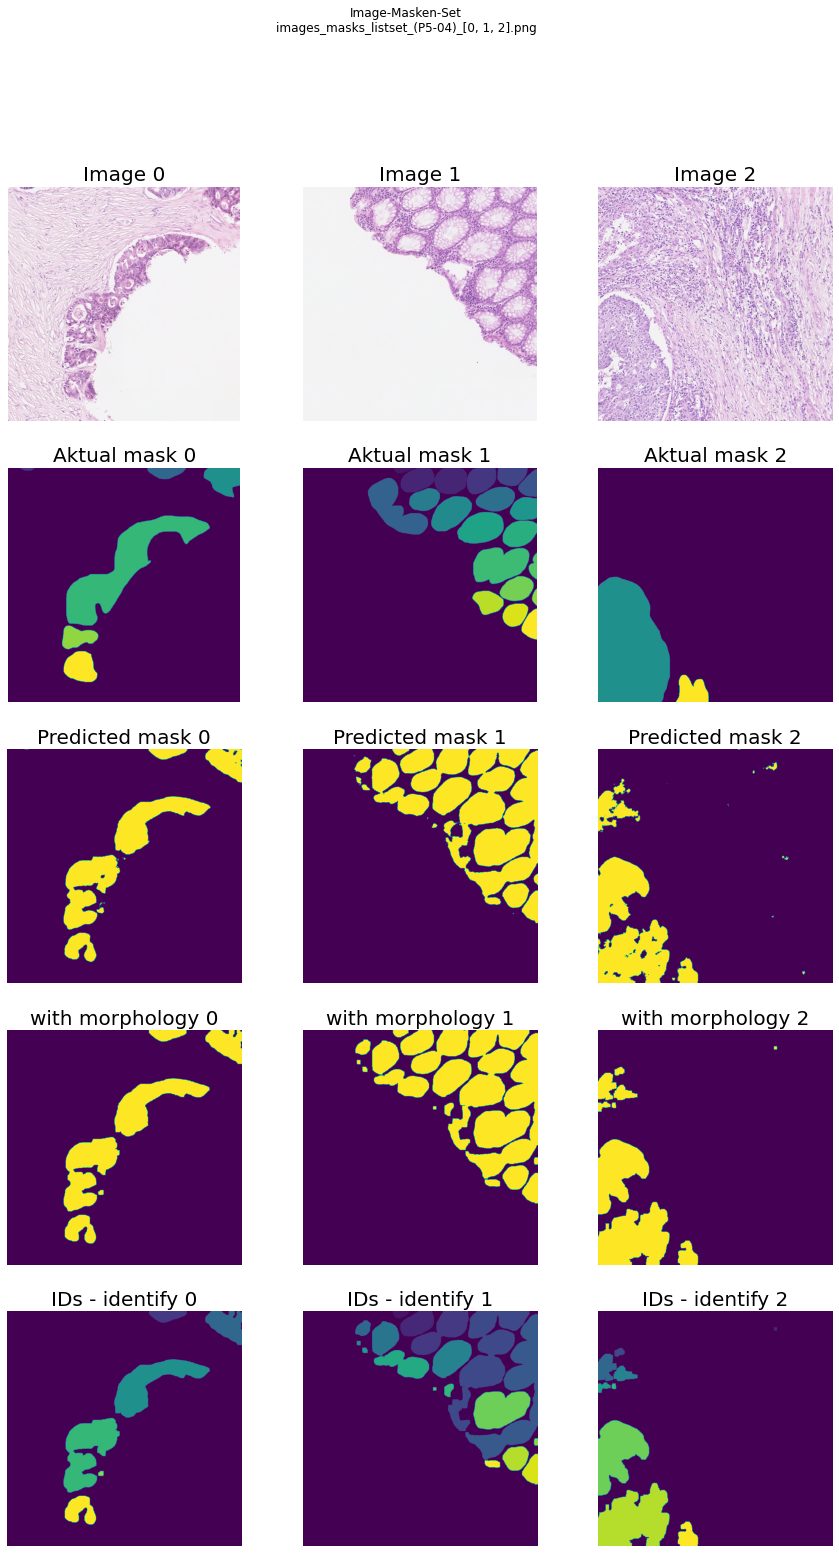

In [ ]:
idx_list=list([25,29,11])
#idx_list=list([10,11,12,13])
idx_list=list([0,1,2])
listset=list([images,  actual_masks,         predict_masks, predict_masks_morph_list,  object_array_list])
titles=list(['Image', 'Aktual mask', 'Predicted mask', 'with morphology',    'IDs - identify'])
path_set= path_result_experiment  / f'images_masks_listset_(P5-04)_{str(idx_list)}.png'
show.list_set(idx_list, listset, titles, path=path_set)

## Save the results

In [ ]:
# Save images, masks and predicted masks of the test images.
for idx in range(sample_anzahl):
    print('idx:', idx, end=', ')
    # All files have the same file name, but are saved in different directories.
    file_name=f'result_test_{idx:02d}.png'
    # Convert from ndarray to * .png
    input_image         = Image.fromarray((images_res[idx]*255).astype(np.uint8))
    actual_mask_img     = Image.fromarray((actual_masks_res[idx]).astype(np.uint8))
    predict_mask_img    = Image.fromarray((predict_masks[idx]).astype(np.uint8))
    predict_masks_morph_img = Image.fromarray((predict_masks_morph_list[idx]).astype(np.uint8))
    object_image        = Image.fromarray((object_array_list[idx]).astype(np.uint8))
    # Saving the images including intermediate results
    input_image.save(path_inputImages / file_name)
    actual_mask_img.save(path_actualMasks / file_name)
    predict_mask_img.save(path_predictMasks / file_name)
    predict_masks_morph_img.save(path_predictMasksMorph / file_name)
    object_image.save(path_predictObjects / file_name)
    # Chain code 
    file_name=f'result_test_{idx:02d}.pkl'
    file_codes=open(path_predictContourCodes / file_name, 'wb')
    pickle.dump(contour_codes_list[idx], file_codes)
    file_codes.close()

idx: 0, idx: 1, idx: 2, idx: 3, idx: 4, idx: 5, idx: 6, idx: 7, idx: 8, idx: 9, idx: 10, idx: 11, idx: 12, idx: 13, idx: 14, idx: 15, idx: 16, idx: 17, idx: 18, idx: 19, idx: 20, idx: 21, idx: 22, idx: 23, idx: 24, idx: 25, idx: 26, idx: 27, idx: 28, idx: 29, idx: 30, idx: 31, idx: 32, idx: 33, idx: 34, idx: 35, idx: 36, idx: 37, idx: 38, idx: 39, 

In [ ]:
print('end of prediction')

end of prediction
